In [1]:
from google.colab import drive
drive.mount ('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!unzip /content/drive/'My Drive'/data/kaggle_cats_and_dogs.zip

In [3]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg16
from functools import partial

print(tf.__version__)
print(tf.executing_eagerly())

2.3.0
True


In [4]:
import os
from random import shuffle
from glob import glob

IMG_SIZE = (224, 224)

train_files = glob('train/*.jpg')
test_files = glob('test/*.jpg')

In [26]:
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return vgg16.preprocess_input(img)

def fit_generator(files, batch_size=64):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

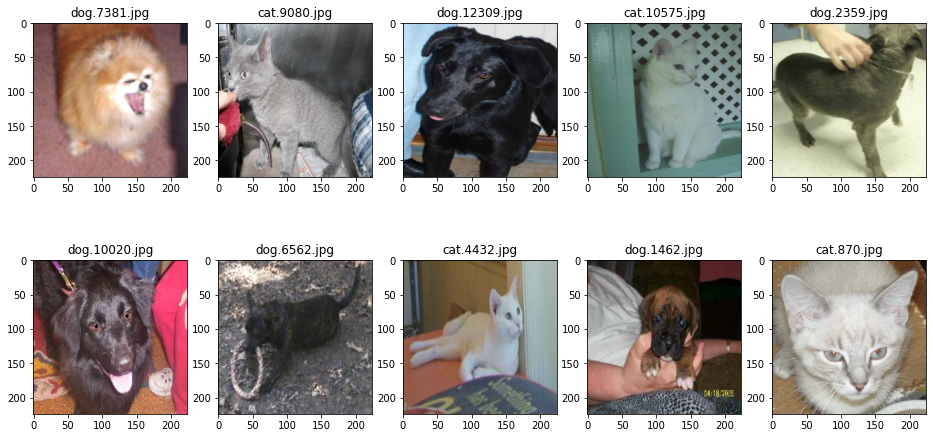

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

In [27]:
base_model = vgg16.VGG16(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

In [28]:
for layer in base_model.layers:
    layer.trainable = False

In [30]:
x = base_model.layers[-5].output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(1024, activation=partial(tf.nn.leaky_relu, alpha=1e-2))(x)
x = tf.keras.layers.Dropout(0.25)(x)
x = tf.keras.layers.Dense(1, activation='sigmoid',
                                kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

In [31]:
model = tf.keras.Model(inputs=base_model.input, outputs=x, name='dogs_vs_cats')

In [32]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, epsilon=1e-8), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [33]:
callback_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                   patience=3,
                                                   verbose=2,
                                                   factor=.5,
                                                   min_lr=1e-10)

callback_ES = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                               patience=7,
                                               restore_best_weights=True)

callbacks = [callback_ES, callback_LR]

In [34]:
shuffle(train_files)
validation_data = next(fit_generator(train_files))
train_data = fit_generator(train_files)

In [41]:
hist = model.fit(train_data,
                 batch_size=128,
                 steps_per_epoch=100,
                 epochs=50,
                 validation_data=validation_data,
                 callbacks=[callbacks])

Epoch 1/50
100/100 [==============================] - 48s 480ms/step - loss: 0.0251 - accuracy: 0.9939 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 2/50
100/100 [==============================] - 48s 479ms/step - loss: 0.0200 - accuracy: 0.9950 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 3/50
100/100 [==============================] - 48s 477ms/step - loss: 0.0198 - accuracy: 0.9959 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 4/50
100/100 [==============================] - ETA: 0s - loss: 0.0166 - accuracy: 0.9950
Epoch 00004: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
100/100 [==============================] - 48s 478ms/step - loss: 0.0166 - accuracy: 0.9950 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 5/50
100/100 [==============================] - 48s 478ms/step - loss: 0.0142 - accuracy: 0.9972 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 6/50
100/100 [==============================] - 48s 478ms/step - loss: 0.0100 - accuracy: 0.9980 - val_l

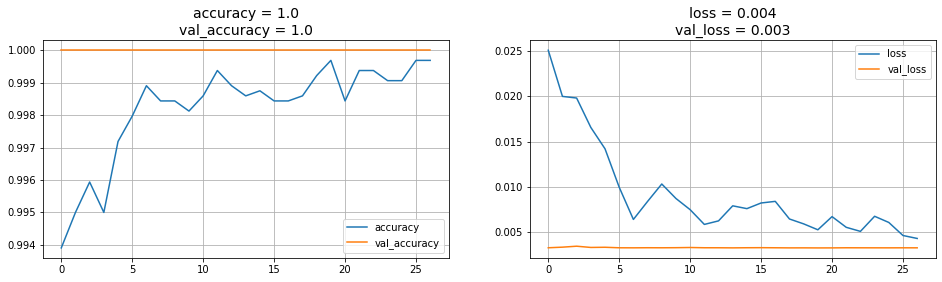

In [43]:
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title(('accuracy = {}\nval_accuracy = {}'.format(round(hist.history['accuracy'][-1],3), 
                                                   round(hist.history['val_accuracy'][-1],3))), fontsize=14)
plt.grid(True)
plt.subplot(122)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.title(('loss = {}\nval_loss = {}'.format(round(hist.history['loss'][-1],3), 
                                           round(hist.history['val_loss'][-1],3))), fontsize=14)
plt.grid(True)
plt.show();

In [44]:
test_pred = model.predict(predict_generator(test_files),
                          steps=len(test_files))

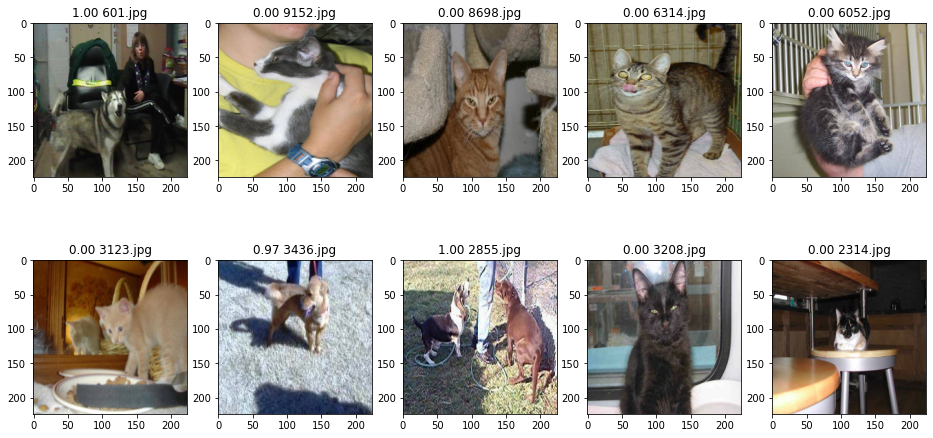

In [45]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

In [46]:
import pandas as pd

submission = pd.DataFrame(columns=['id', 'label'], index=[i for i in range(len(test_pred))])

for name, score, row in zip(test_files, test_pred, range(len(test_pred))):
    submission.loc[row]['id'] = name.split('/')[1].split('.')[0]
    submission.loc[row]['label'] = float(np.round(score, decimals=5))

submission.head()

,id,label
0,601,0.99976
1,9152,0
2,8698,0
3,6314,0
4,6052,0


In [47]:
submission.to_csv('submission.csv', index=False)